# Natural Earth - Map Layering
This notebook explores layering different cultural, physical, and raster features for visualization

## Setup

In [1]:
from pathlib import Path 
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

In [2]:
# Basic pathing
data_path = Path.joinpath(Path.cwd().parent.parent, "data")
natural_earth_10m_path = Path.joinpath(data_path, "natural_earth", "10m")
assert natural_earth_10m_path.is_dir()

## Raster Layer

In [3]:
# Load up raster layer first
raster_path = Path.joinpath(natural_earth_10m_path, "raster", "HYP_HR_SR_OB_DR", "HYP_HR_SR_OB_DR.tif")

# Open the raster file
with rasterio.open(raster_path) as src:
    raster_data = src.read(1) 
    raster_crs = src.crs
    raster_bounds = src.bounds
    raster_transform = src.transform

In [5]:
# Understand the raster data (numpy array w/ 3 channels)
print(f"Shape: {raster_data.shape}")
print(f"Data Type: {raster_data.dtype}")
print(f"Raster CRS (Coordinate Reference System): {raster_crs}")
print(f"Raster Bounds: {raster_bounds}")

    
"""
How to read this.
### EXAMPLE
Raster Shape: (10800, 21600)
Raster Data: uint8
Raster CRS (Coordinate Reference System): GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Raster Bounds: BoundingBox(left=-180.0, bottom=-90.000000000036, right=180.00000000007202, top=90.00000000000001)

Raster Shape:
There are 10800 rows and 21600 columns. Each cell represents an area of the world.

Raster Data:
Provided as unsigned integer 0-255, not as float.

Raster CRS: 
Defines how the grid relates to real world locations on Earth. 
WGS 84 (World Geodetic System 1984) - very common system in GPS and applications
    - positions on Earth's surface described using latitude and longitude in degrees.
    - DATUM = Reference surface (spheroid) used for measuring
    - SPHEROID =  Describes Earth's shape using a semi-major axis (6,378,137 meters) and flattening ratio (1/298.257223563).
    - UNIT = specifies degrees. 
    - AXIS = Latitude increases from South to North, and Longitude increases from West to East.
    
Raster Bounds: 
Defines extent of the raster in terms of latitude and longitude.
    - Left: -180.0 degrees longitude (far west, International Date Line in the Pacific Ocean)
    - Bottom: -90.0 degrees latitude (South Pole)
    - Right: 180.0 degrees longitude (far east, again the International Date Line)
    - Top: Top: 90.0 degrees latitude (North Pole)
Because it stretches from the international date line to the same line, and from north pole to south, this covers the whole Earth.
"""

Shape: (10800, 21600)
Data Type: uint8
Raster CRS (Coordinate Reference System): EPSG:4326
Raster Bounds: BoundingBox(left=-180.0, bottom=-90.000000000036, right=180.00000000007202, top=90.00000000000001)


'\nHow to read this.\n### EXAMPLE\nRaster Shape: (10800, 21600)\nRaster Data: uint8\nRaster CRS (Coordinate Reference System): GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]\nRaster Bounds: BoundingBox(left=-180.0, bottom=-90.000000000036, right=180.00000000007202, top=90.00000000000001)\n\nRaster Shape:\nThere are 10800 rows and 21600 columns. Each cell represents an area of the world.\n\nRaster Data:\nProvided as unsigned integer 0-255, not as float.\n\nRaster CRS: \nDefines how the grid relates to real world locations on Earth. \nWGS 84 (World Geodetic System 1984) - very common system in GPS and applications\n    - positions on Earth\'s surface described using latitude and longitude in degrees.\n    - DATUM = Reference surface (spheroid) used for measuring\n    - SPHEROID =  Describes Earth\'s shape using a sem

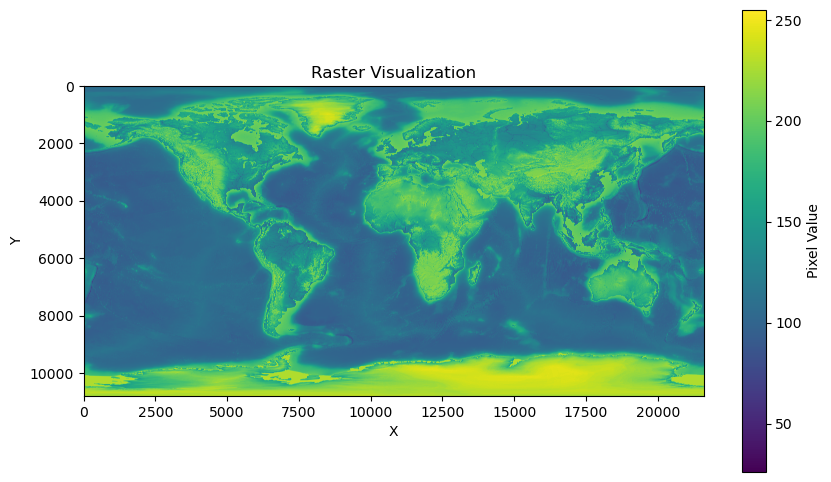

In [6]:
# Visualize the raster using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(raster_data, cmap='viridis')
plt.colorbar(label='Pixel Value')
plt.title('Raster Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Cultural (Vector) Layer

In [7]:
# Load up raster layer first
vector_path = Path.joinpath(natural_earth_10m_path, "cultural", "10m_cultural", "10m_cultural", "ne_10m_time_zones.shp")

# Open up file
gdf = gpd.read_file(vector_path)

<Axes: >

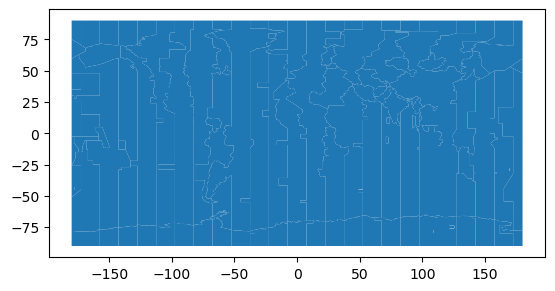

In [8]:
# Show off file - you can see the time zones
gdf.plot()

## Combining Layers

In [9]:
# First we need to check that they are in the same CRS and if not, reproject them to the same coordinate system
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)  # Reproject the vector to match the raster's CRS


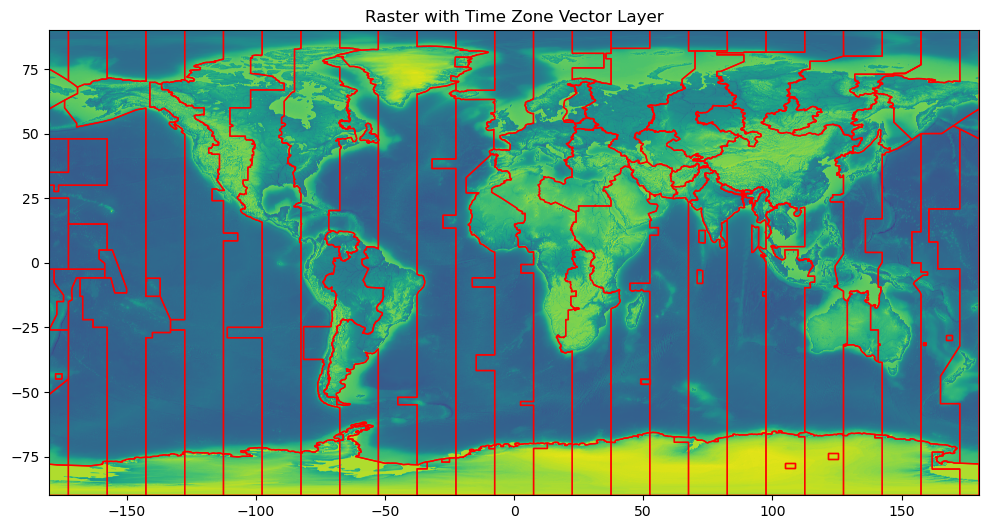

In [10]:
# Now plot them together
fig, ax = plt.subplots(figsize=(12, 8))
show(raster_data, transform=raster_transform, ax=ax, cmap='viridis')  # Display the raster

# Plot the vector data (like time zone boundaries) on top
gdf.boundary.plot(ax=ax, color='red', linewidth=1)  # Draw time zone boundaries

# Additional Plot Customization
ax.set_title('Raster with Time Zone Vector Layer')
plt.show()

## Zooming in to the US
This is great and all, but what if I want to zoom into just the United States (mainland). 

In [11]:
# Need to get coordinates for the bounding box of the US
us_bounds = {
    'left': -125.0,  # Western longitude bound
    'right': -66.0,  # Eastern longitude bound
    'bottom': 24.0,  # Southern latitude bound
    'top': 49.5  # Northern latitude bound
}

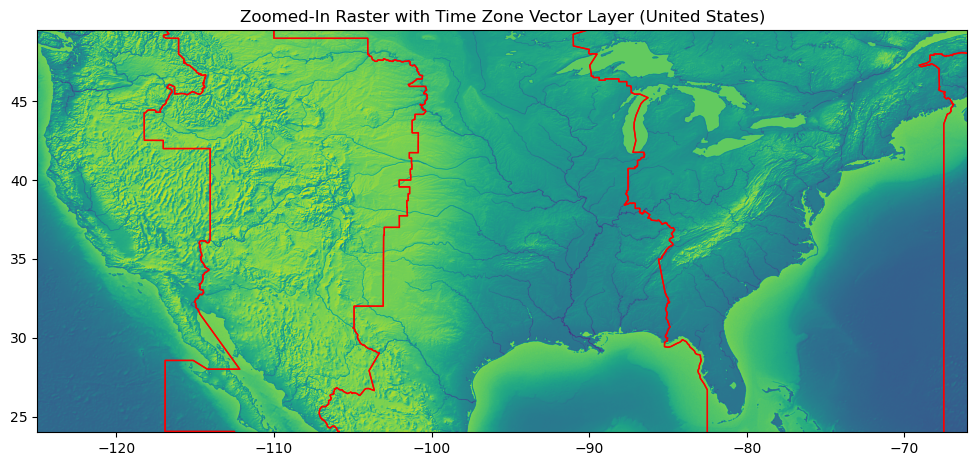

In [12]:
# Now we can chop the visualization to focus on the us
fig, ax = plt.subplots(figsize=(12, 8))
show(raster_data, transform=raster_transform, ax=ax, cmap='viridis')  # Display the raster

# Plot the vector data (like time zone boundaries) on top
gdf.boundary.plot(ax=ax, color='red', linewidth=1) 
ax.set_xlim(us_bounds['left'], us_bounds['right'])  # Set longitude bounds (X-axis)
ax.set_ylim(us_bounds['bottom'], us_bounds['top'])  # Set latitude bounds (Y-axis)
ax.set_title('Zoomed-In Raster with Time Zone Vector Layer (United States)')
plt.show()

# Features that lie within small boundary of the map

In [13]:
# Load up vectory layer
vector_path = Path.joinpath(natural_earth_10m_path, "cultural", "10m_cultural", "10m_cultural", "ne_10m_admin_0_countries_fra.shp")

# Open up file
gdf = gpd.read_file(vector_path)

In [14]:
# First we need to check that they are in the same CRS and if not, reproject them to the same coordinate system
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)  # Reproject the vector to match the raster's CRS


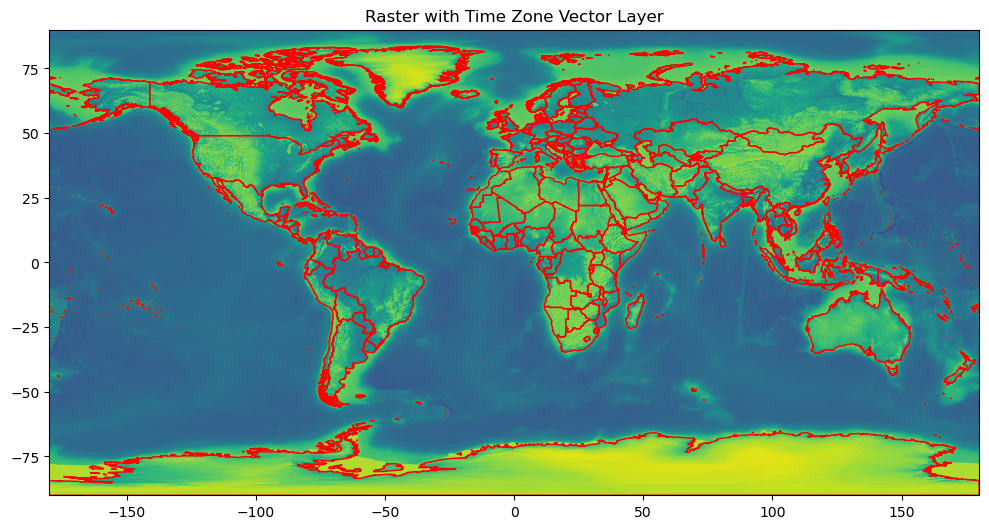

In [ ]:
# Now plot them together
fig, ax = plt.subplots(figsize=(12, 8))
show(raster_data, transform=raster_transform, ax=ax, cmap='viridis')  # Display the raster

# Plot the vector data (like time zone boundaries) on top
gdf.boundary.plot(ax=ax, color='red', linewidth=1)  # Draw time zone boundaries

# Additional Plot Customization
ax.set_title('Raster swith Time Zone Vector Layer')
plt.show()